# Goal: Predict Furture 12 hours' temperature by Past 6 hours temperature

In [1]:
from google.colab import drive # Import a library named google.colab
drive.mount('/content/drive', force_remount=True) # mount the content to the directory `/content/drive`

%cd /content/drive/MyDrive/ML_Books

Mounted at /content/drive
/content/drive/MyDrive/ML_Books


In [2]:
fname = 'TY_climate_2015_2018.csv'
f = open(fname, encoding = 'cp950')
data = f.read()
f.close()

In [3]:
lines = data.split('\n')
header = lines[0].split(',')
lines[0] # these are lables

'緯度,經度,測站名稱,測站ID,觀測資料時間,高度,風向,風速,溫度,相對濕度,測站氣壓,日照時數,日累積雨量,小時最大陣風風速,小時最大陣風風向,小時最大陣風風向,縣市,縣市編號,鄉鎮,鄉鎮編號'

In [4]:
del lines[0]

In [5]:
print(len(lines))
print(header)
print()
print(header[8])

196856
['緯度', '經度', '測站名稱', '測站ID', '觀測資料時間', '高度', '風向', '風速', '溫度', '相對濕度', '測站氣壓', '日照時數', '日累積雨量', '小時最大陣風風速', '小時最大陣風風向', '小時最大陣風風向', '縣市', '縣市編號', '鄉鎮', '鄉鎮編號']

溫度


## Start to plot the temparture change

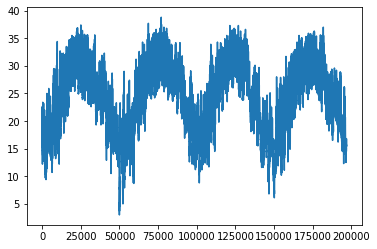

In [6]:
import numpy as np 
from matplotlib import pyplot as plt

raw_data = []
# enumerate will give the count number of the loop (i)
for i, line in enumerate(lines):
    temperature = float(line.split(',')[8]) # get the information 
    raw_data.append(temperature) # for RNN format 

raw_data = np.array(raw_data) # convert it into  numpy array 
plt.plot(raw_data)
plt.show()

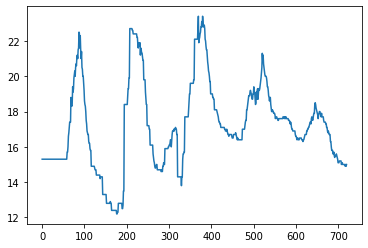

In [7]:
plt.plot(raw_data[:720]) # the data is recorded every 10 minutes, so a day have 144 datas
plt.show()

## Because we are going to use first 100000 data as our training data, we have to use first 100000 data to standarize every data.
## Standarization can improve the prediction.

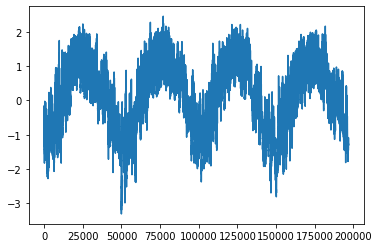

In [8]:
# for the standarization 
# print(raw_data)
mean = raw_data[:100000].mean()
raw_data -= mean 
std = raw_data[:100000].std()
raw_data /= std
plt.plot(raw_data)
plt.show()

## Create the data type for RNN  

In [9]:
new_raw_data=[]
for i in range(len(raw_data)):
    new_raw_data.append([raw_data[i]])
print(type(new_raw_data))
new_raw_data = np.array(new_raw_data)
print(type(new_raw_data))

<class 'list'>
<class 'numpy.ndarray'>


## The next step is to use the TimeseriesGenerator Object for the Sequence

In [10]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 

length = 36
delay = 72 # 12hours equals to 6*12  data in this case 
sampling_rate = 3
stride = 36 # 6 hours 
batch_size = 32 

data = new_raw_data[:-(delay-1)]
target = new_raw_data[(delay-1):] 

# Create Training Data 
train_gen = TimeseriesGenerator(data, target, 
                               length=length,
                               sampling_rate=sampling_rate,
                               stride=stride,
                               start_index=0,
                               end_index=100000,
                               batch_size=batch_size)
# Create Validation Data 
val_gen = TimeseriesGenerator(data, target, 
                               length=length,
                               sampling_rate=sampling_rate,
                               stride=stride,
                               start_index=100001,
                               end_index=130000,
                               batch_size=batch_size)
# Create Testing Data 
test_gen = TimeseriesGenerator(data, target, 
                               length=length,
                               sampling_rate=sampling_rate,
                               stride=stride,
                               start_index=130001,
                               end_index=None,
                               batch_size=batch_size)

In [11]:
print(train_gen[0][0].shape) 
# batch_size, time_series, feature_amount

(32, 12, 1)


In [12]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers

dense_model = Sequential([
                    # time_series, feature_amount
    layers.Flatten(input_shape=(12, 1)),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
])
dense_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                130       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________


In [13]:
dense_model.compile(optimizer='rmsprop', loss='mse',
                   metrics=['mae']) 
# Cause this is a regression problem, so use mse will have some good improvement 

In [14]:
dense_history = dense_model.fit(train_gen,
                               epochs=100,
                               validation_data=val_gen)

Epoch 1/100
87/87 [==============================] - 1s 4ms/step - loss: 0.4340 - mae: 0.5316 - val_loss: 0.3655 - val_mae: 0.4988
Epoch 2/100
87/87 [==============================] - 0s 3ms/step - loss: 0.2964 - mae: 0.4382 - val_loss: 0.3443 - val_mae: 0.4751
Epoch 3/100
87/87 [==============================] - 0s 3ms/step - loss: 0.2830 - mae: 0.4272 - val_loss: 0.3340 - val_mae: 0.4721
Epoch 4/100
87/87 [==============================] - 0s 3ms/step - loss: 0.2734 - mae: 0.4194 - val_loss: 0.3291 - val_mae: 0.4533
Epoch 5/100
87/87 [==============================] - 0s 2ms/step - loss: 0.2664 - mae: 0.4123 - val_loss: 0.3230 - val_mae: 0.4469
Epoch 6/100
87/87 [==============================] - 0s 3ms/step - loss: 0.2603 - mae: 0.4077 - val_loss: 0.3106 - val_mae: 0.4427
Epoch 7/100
87/87 [==============================] - 0s 3ms/step - loss: 0.2537 - mae: 0.4009 - val_loss: 0.3116 - val_mae: 0.4425
Epoch 8/100
87/87 [==============================] - 0s 3ms/step - loss: 0.2520 - m

In [16]:
print("The average temperature error:", dense_history.history['val_mae'][-1]*std)

The average temperature error: 2.382736596989042


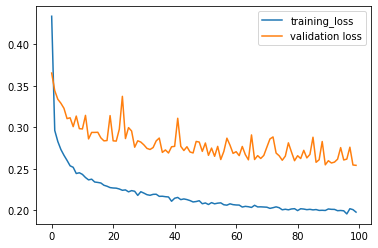

In [17]:
plt.plot(dense_history.history['loss'], label='training_loss')
plt.plot(dense_history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

## Test 1: use RNN to predict Future Temperature

In [18]:
rnn_model = Sequential([
    layers.SimpleRNN(10, input_shape=(12, 1)),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)  
])
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


In [19]:
rnn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
rnn_history = rnn_model.fit(train_gen, epochs=100, validation_data=val_gen)

Epoch 1/100
87/87 [==============================] - 2s 7ms/step - loss: 0.6633 - mae: 0.6609 - val_loss: 0.4738 - val_mae: 0.5596
Epoch 2/100
87/87 [==============================] - 0s 5ms/step - loss: 0.4188 - mae: 0.5158 - val_loss: 0.3658 - val_mae: 0.4833
Epoch 3/100
87/87 [==============================] - 0s 4ms/step - loss: 0.3510 - mae: 0.4717 - val_loss: 0.3482 - val_mae: 0.4654
Epoch 4/100
87/87 [==============================] - 0s 4ms/step - loss: 0.3261 - mae: 0.4556 - val_loss: 0.3412 - val_mae: 0.4625
Epoch 5/100
87/87 [==============================] - 0s 4ms/step - loss: 0.3086 - mae: 0.4405 - val_loss: 0.3344 - val_mae: 0.4589
Epoch 6/100
87/87 [==============================] - 0s 5ms/step - loss: 0.2947 - mae: 0.4316 - val_loss: 0.3279 - val_mae: 0.4482
Epoch 7/100
87/87 [==============================] - 0s 5ms/step - loss: 0.2804 - mae: 0.4166 - val_loss: 0.3200 - val_mae: 0.4458
Epoch 8/100
87/87 [==============================] - 0s 5ms/step - loss: 0.2708 - m

In [20]:
print("The average temperature error:", rnn_history.history['val_mae'][-1]*std)

The average temperature error: 2.323521217822103


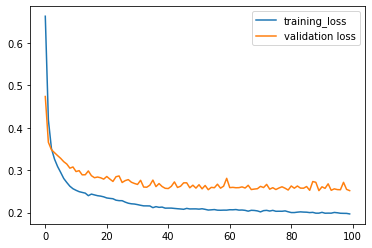

In [21]:
plt.plot(rnn_history.history['loss'], label='training_loss')
plt.plot(rnn_history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

## Compare RNN and Dense Neural Network

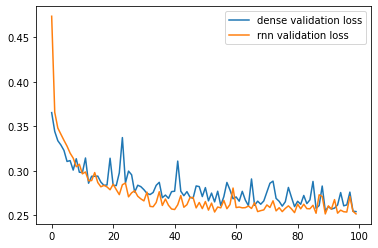

In [22]:
plt.plot(dense_history.history['val_loss'], label='dense validation loss')
plt.plot(rnn_history.history['val_loss'], label='rnn validation loss')
plt.legend()
plt.show()

## We have to try to generate Stateful RNN Module Data

In [23]:
def statefulGenerator(data, target,
                      length=1,
                      sampling_rate=1,
                      stride=1,
                      start_index=0,
                      end_index=None, 
                      batch_size=128):
  if end_index==None: end_index=len(data)-1
  data_len = ((end_index-start_index+1)-length)//stride 
  tmp_batch_size = data_len//batch_size  # we can modify it from setting(32) to 1 when prediction

  end_index = tmp_batch_size*batch_size*stride + (length-1) + start_index  
  data_gen = TimeseriesGenerator(data, target, 
                               length=length,
                               sampling_rate=sampling_rate,
                               stride=stride,
                               start_index=start_index,
                               end_index=end_index,
                               batch_size=tmp_batch_size)
  
  new_data = []
  new_target = []

  for i in data_gen:
    new_data.append(i[0])
    new_target.append(i[1])
  
  new_data = np.array(new_data)
  new_target = np.array(new_target)

  new_data = new_data.transpose(1, 0, 2, 3)
  new_target = new_target.transpose(1, 0, 2)

  new_data_gen = []
  for i in range(len(new_data)):
    new_data_gen.append((new_data[i], new_target[i]))

  return new_data_gen


In [24]:
# Create Training Data 
state_train_gen = statefulGenerator(data, target, 
                               length=length,
                               sampling_rate=sampling_rate,
                               stride=stride,
                               start_index=0,
                               end_index=100000,
                               batch_size=batch_size)
# Create Validation Data 
state_val_gen = statefulGenerator(data, target, 
                               length=length,
                               sampling_rate=sampling_rate,
                               stride=stride,
                               start_index=100001,
                               end_index=130000,
                               batch_size=batch_size)
# Create Testing Data 
state_test_gen = statefulGenerator(data, target, 
                               length=length,
                               sampling_rate=sampling_rate,
                               stride=stride,
                               start_index=130001,
                               end_index=None,
                               batch_size=batch_size)

In [29]:
state_model = Sequential([
              layers.SimpleRNN(10, stateful=True, batch_input_shape=(32, 12, 1)),
              layers.Dense(10, activation='relu'),
              layers.Dense(1)
])
state_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (32, 10)                  120       
_________________________________________________________________
dense_7 (Dense)              (32, 10)                  110       
_________________________________________________________________
dense_8 (Dense)              (32, 1)                   11        
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


## Turn the StatefulGenerator tuple to keras Sequence

In [30]:
from tensorflow.python.keras.utils.data_utils import iter_sequence_infinite as iter_inf 
state_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

epochs = 100
loss = []
val_loss = []
for i in range(epochs):
  print('Epoch', i+1, '/', epochs)
  state_history = state_model.fit_generator(iter_inf(state_train_gen),
                                  steps_per_epoch=len(state_train_gen),
                                  validation_data=iter_inf(state_val_gen),
                                  validation_steps=len(state_val_gen),
                                  epochs=1,
                                  verbose=1,
                                  shuffle=False) # Because the time series
  loss.append(state_history.history['loss'])
  val_loss.append(state_history.history['val_loss'])
  state_model.reset_states()

Epoch 1 / 100


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


86/86 [==============================] - 1s 6ms/step - loss: 0.4321 - mae: 0.5166 - val_loss: 0.3328 - val_mae: 0.4480
Epoch 2 / 100
86/86 [==============================] - 0s 4ms/step - loss: 0.2753 - mae: 0.4152 - val_loss: 0.3117 - val_mae: 0.4354
Epoch 3 / 100
86/86 [==============================] - 0s 4ms/step - loss: 0.2641 - mae: 0.4054 - val_loss: 0.3226 - val_mae: 0.4417
Epoch 4 / 100
86/86 [==============================] - 0s 4ms/step - loss: 0.2560 - mae: 0.3970 - val_loss: 0.3171 - val_mae: 0.4374
Epoch 5 / 100
86/86 [==============================] - 0s 4ms/step - loss: 0.2478 - mae: 0.3889 - val_loss: 0.3109 - val_mae: 0.4335
Epoch 6 / 100
86/86 [==============================] - 0s 4ms/step - loss: 0.2446 - mae: 0.3848 - val_loss: 0.3072 - val_mae: 0.4283
Epoch 7 / 100
86/86 [==============================] - 0s 4ms/step - loss: 0.2399 - mae: 0.3799 - val_loss: 0.3065 - val_mae: 0.4275
Epoch 8 / 100
86/86 [==============================] - 0s 4ms/step - loss: 0.2388 -

In [33]:
print("The average temperature error:", state_history.history['val_mae'][-1]*std)

The average temperature error: 2.134915434487681


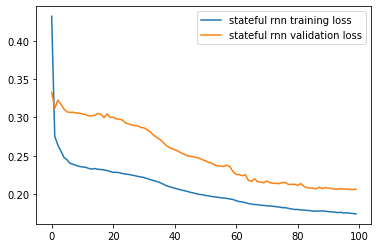

In [34]:
plt.plot(loss, label='stateful rnn training loss')
plt.plot(val_loss, label='stateful rnn validation loss')
plt.legend()
plt.show()

# The comparison of 3 method

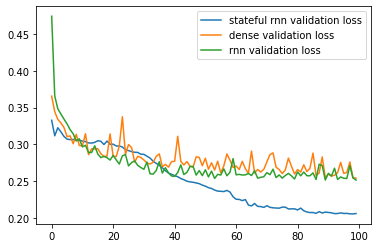

In [35]:
plt.plot(val_loss, label='stateful rnn validation loss')
plt.plot(dense_history.history['val_loss'], label='dense validation loss')
plt.plot(rnn_history.history['val_loss'], label='rnn validation loss')

plt.legend()
plt.show()

In [66]:
# evaluation will return loss and error
print('Dense Neural Networl error:', dense_model.evaluate(test_gen, steps=None, verbose=0)[1])
print("RNN error:", rnn_model.evaluate(test_gen, steps=None, verbose=0)[1])
print("Stateful RNN error:", state_model.evaluate(iter_inf(state_test_gen), steps=len(state_test_gen), verbose=0)[1])

Dense Neural Networl error: 0.3509666621685028
RNN error: 0.3497828543186188
Stateful RNN error: 0.32378363609313965


In [60]:
val_temp = []
for datas in val_gen:
  for temp in datas[1]:
    val_temp.append(temp)

In [57]:
state_model.reset_states()
prediction = state_model.predict_generator(iter_inf(state_val_gen), steps=len(state_val_gen))
print(prediction.shape)

(832, 1)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [58]:
prediction = prediction.reshape(len(prediction)//32, 32)
print(prediction.shape)
prediction = prediction.transpose(1, 0)
print(prediction.shape)
prediction = prediction.reshape(-1, )
print(prediction.shape)

(26, 32)
(32, 26)
(832,)


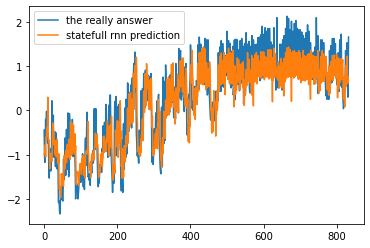

In [63]:
plt.plot(val_temp, label='the really answer')
plt.plot(prediction, label='statefull rnn prediction')
plt.legend()
plt.show()

# Final Big Tip: Using the weight of training model to predict another size of batch

In [68]:
state_model2 = Sequential([
                       #                                            batch size, any timeseries, one feature
                       layers.SimpleRNN(10, stateful=True, batch_input_shape=(1, None, 1)),
                       layers.Dense(10, activation='relu'),
                       layers.Dense(1)    
])

In [69]:
state_model2.set_weights(state_model.get_weights())

## Now we can just input data to model2 with batch size 1